#### *Man is a deterministic device thrown in a probabilistic universe.* $\sim$ *Amos Tversky, 1972.*

This is an introductory post on Bayesian Modeling. Here, I go over relevant concepts by using an existing model, the ocean color 4-band chlorophyll algorithm OC4. This is a polynomial regression that uses remote sensing reflectance and returns chlorophyll *a* concentration. This model is in common usage and should be familiar to the earth science afficionado dabbling in satellite oceanography. This assumed familiarity allows me to focus on the bayesian modeling mechanics and to lay the groundwork for more complex model development and experiments featured in subsequent posts. 

This notebook is a hands-on computational platform comprised of alternating code cells and markdown cells; code cells are meant to be executed and may carry succint comments prefixed with a '#', while adjacent markdown cells communicate context and relevant explanations.  The idea is for anyone interested in hands-on experimenting to clone the repository, and re-run the code cells. The code snippets presuppose familiarity with the python programming language, but are not essential for following along. Regardless, python is pretty readable, almost pseudocode-like, and the interested reader should be able to get a sense of what is going on by inspecting the model setups 

In [1]:
# IMPORTS

# stdlib
import os
import pathlib
import sys
import pickle

# numeric
import pandas as pd # a tabular data manipulation framework
import numpy as np #  linear algebra package 
import pymc3 as pm # bayesian modeling package
import scipy.stats as stats # as named

# visualization
import seaborn as sb # for pretty graphs
import matplotlib.pyplot as pl # graphics backend

# look & feel
from IPython.core.display import HTML, display

In [2]:
print("Software Versions:")
print(f'Python: {sys.version}')
print('-' * 75)
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pymc3: {pm.__version__}')
print(f'seaborn: {sb.__version__}')

Software Versions:
Python: 3.6.4 |Anaconda custom (x86_64)| (default, Dec 21 2017, 15:39:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
---------------------------------------------------------------------------
numpy: 1.13.3
pandas: 0.22.0
pymc3: 3.2
seaborn: 0.8.1


In [3]:
# graphical setup

% matplotlib inline
rc_ = {}
rc_['xtick.labelsize'] = 14
rc_['ytick.labelsize'] = 14
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 14
rc_['font.size'] = 14
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18
sb.set_style(style='darkgrid', rc=rc_)
sb.set_context(context='paper', rc=rc_)
display(HTML("<style>.container {width: 90% !important}</style>"))

As mentioned earlier, for this tutorial I'll focus on chlorophyll algorithms from the OC4 family. The input is based on remote sensing reflectance. The OC4 algorithm takes the following form:

### $$ log_{10}\left(chlor\_a\right) = \alpha + \sum_{i=1}^{4}\beta_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

where by convention $\alpha$s and $\beta$s represent intercepts and slopes respectively.
First I load the data, specific to the SeaWiFS sensor into a (pandas -- see IMPORTS) dataframe.

In [4]:
root = './pickleJar/'
dfNomadV2 = pd.read_pickle(os.path.join(root, 'dfNOMADV2.pkl'))

Next, I display the first five lines of the dataframe for reference.

In [5]:
dfNomadV2.head()

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,sst,lat,lon,datetime,chl_all
0,1565,0.0,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,NaN,38.19,3.70,38.4279,-76.61,2003-04-15 15:15:00,38.19
1,1566,0.0,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,NaN,35.01,3.70,38.3680,-76.50,2003-04-15 16:50:00,35.01
2,1567,1.0,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,NaN,26.91,3.70,38.3074,-76.44,2003-04-15 17:50:00,26.91
3,1568,3.0,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,NaN,47.96,3.70,38.6367,-76.32,2003-04-17 18:15:00,47.96
4,1559,1.0,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,NaN,23.55,22.03,38.3047,-76.44,2003-07-21 18:27:00,23.55


Below, I create the features used in the inference from the rrs data. This means computing $\frac{max(Rrs(\lambda_{blue})}{Rrs(\lambda_{green})}$ and create a column, named *mxBl2Gr*, to hold the result in a new dataframe built below.

In [6]:
df = dfNomadV2.filter(regex='rrs')
df.insert(0, 'id', dfNomadV2.id)
df.insert(df.shape[1], 'chlor_a', dfNomadV2.chl_all)
df.insert(df.shape[1]-1, 'maxBlue', df.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1))
df.insert(df.shape[1]-1, 'mxBl2Gr', df.maxBlue / df.rrs555)
df.head()

,id,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,maxBlue,mxBl2Gr,chlor_a
0,1565,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,0.004036,0.539676,38.19
1,1566,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,0.002499,0.601926,35.01
2,1567,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,0.002288,0.538844,26.91
3,1568,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,0.003664,0.524837,47.96
4,1559,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,0.001903,0.679622,23.55


#### feature creation 
Next is to take the $log_{10}$ of both predictor, mxBl2Gr, and chlor_a, as specified in the algorithm listing above. Note that, for each observation, I also store which $Rrs(\lambda_{blue})$ is used in the $max(Rrs(\lambda_{blue}))$ in a new column named mxBlId. This will be useful later down the road, for a different kind of model.

In [7]:
dfLogOC4 = pd.DataFrame(columns=['id','mxBl2Gr',  'mxBlId', 'chlor_a'])
dfLogOC4['id'] = df.id
dfLogOC4['mxBlId'] = dfNomadV2.loc[:, ['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1)
dfLogOC4['mxBl2Gr'] = np.log10(df.mxBl2Gr.values)
dfLogOC4['chlor_a'] = np.log10(df.chlor_a.values)

Done. This constitutes the training dataset I'll use to build the model.

In [8]:
dfLogOC4.head()

,id,mxBl2Gr,mxBlId,chlor_a
0,1565,-0.267867,rrs510,1.581950
1,1566,-0.220457,rrs510,1.544192
2,1567,-0.268537,rrs510,1.429914
3,1568,-0.279976,rrs510,1.680879
4,1559,-0.167733,rrs510,1.371991


The next plot shows how the data is distributed and how it is pairwise-related.

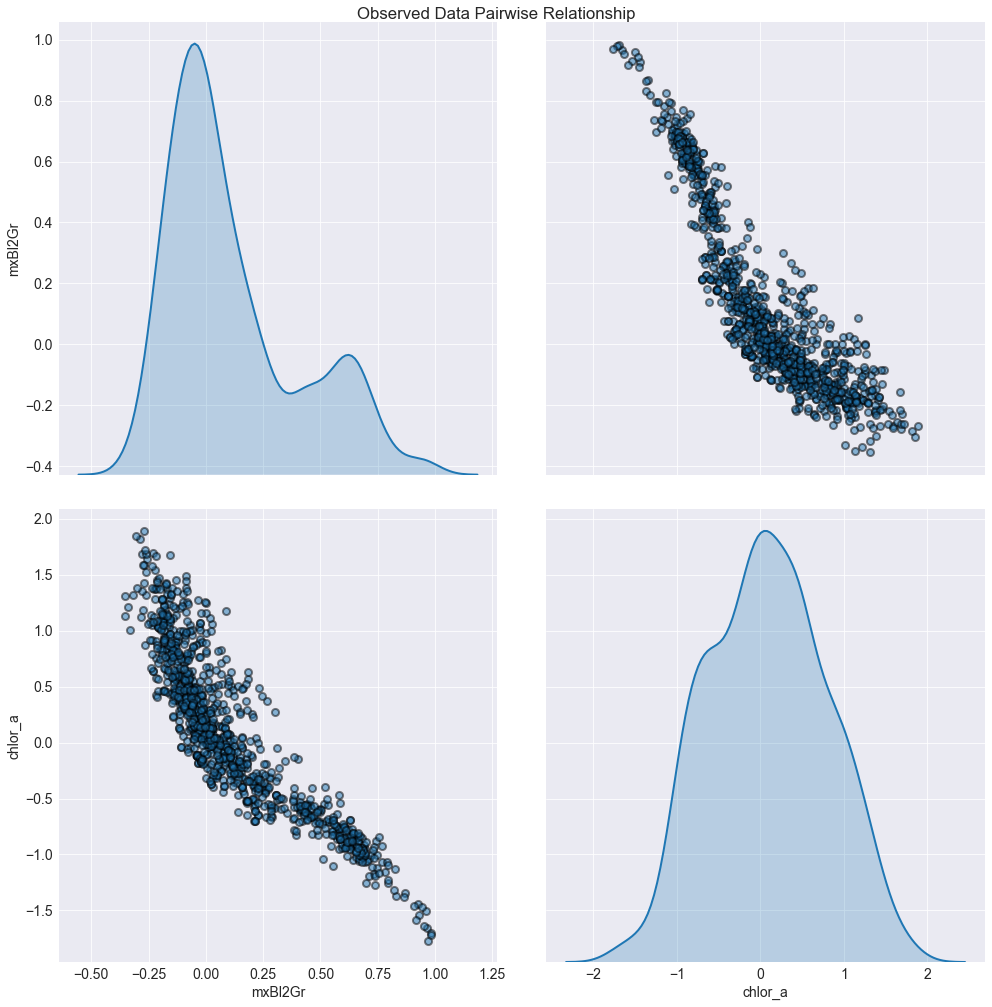

In [10]:
sb.pairplot(dfLogOC4.drop(['id', 'mxBlId'], axis=1), size=7, diag_kind="kde", markers="o",
                          plot_kws=dict(s=50, edgecolor="k", alpha=0.5,
                                        linewidth=2), diag_kws=dict(shade=True, linewidth=2));
f = pl.gcf()
f.suptitle('Fig. 1 - Observed Data Pairwise Relationship', y=1.0);
f.tight_layout()

**A rushed overview of Bayesian inference**:

Bayes rule stipulates that the conjugate probability of two events $A$ and $B$, $P(A,B)$ can be computed by one of the following equalities: 

$$P(A,B) = P(A|B) P(B) = P(B|A)P(A)$$

where P(A|B) is the conditional probability that A is observed given that B has already occurred.

This becomes quite useful in the event that one of the conditional probability is easier to compute than the other. If, for instance, P(A|B) is hard to compute but P(B|A), P(B) and P(A) are easily obtained, then the above can be conveniently manipulated to yield

$$P(A|B) = \frac{P(B|A) P(A)}{P(B)} \hspace{1cm}(1)$$

In a scientific context Bayes rule is applied to identify the probability of a given hypothesis in view of a set of observation, modulated by what is known a priori about the hypothesis. If $H$ refers to a particular *Hypothesis* of interest, and $D$ is *Data* collected to assess the validity of this, *Hypothesis*, Bayes rule can be recast as:

$$P(H|D) = \frac{P(D|H)P(H)}{P(D)}$$

where 

* $P(H)$, **the prior**, expresses what the practitioner (this subjectivity is important) knows of the process of interest prior to collecting the data,
* $P(D|H)$, **the likelihood**, is the probability of the $D$ given $H$. In Maximum Likelihood Estimation, this is the quantity that is optimized; usually by taking its negative log and then minimizing. 
* $P(D)$ **the evidence**, and is the reason, by virtue of numerical intractability in all but the most trivial cases, of the late adoption of bayesian statistics. The declassification of WWII and Cold War intelligence documents, the democratization of massive computing power and the arrival of the Markov Chain Monte Carlo (MCMC) algorithm have essentially put an end to a 200+ year debate. The history makes for an interesting read; *eg*. see [here](https://yalebooks.yale.edu/book/9780300188226/theory-would-not-die). The point is that $P(D)$ will no longer be mentioned, because MCMC avoids its computation.
* $P(H|D)$, **the posterior**, expresses the re-evaluated probability of $H$ after confrontation with data $D$.  When new data becomes available, the old posterior becomes the new prior, reflecting an update in knowledge.

In the present problem of regression, a given $H$ can be taken as the set of values taken by the coefficients to be fit.


That's it for the theory. The next step is to specify a model. For this I will use PyMC3, a  probabilistic programming library written in Python, that is very handy for rapid model prototyping.

The code cell below specifies the implementation of the model in the probabilistic programming paradigm mentioned before. The 'with' command with subsequent indentation is a model context construct, informing the interpreter what to access for a particular (related) task. This significantly reduces code, increasing readability and making debugging much easier. 

For reference, the model general structure is depicted below; this will be the same for all models created in this notebook. In as [subsequent notebook]() I will create models of different, usually more complex structure.

<img src="kruschke_diagrams/oc34.png">


**Brief aside on the priors of the model**:

In the first model, below, I use gaussian distributions centered at 0 with a standard deviation of 10 for the regression parameters. A gaussian is a well understood distribution that, moreover, is easy to deal with. The use of a gaussian is justified by Information Theory. Given that I am willing to assume that the parameters are distributed with finite variance, a gaussian is the distribution that corresponds to a greater count of outcomes that do not violate my assumptions of finite variance. To put it differently, given the current state of my ignorance, this distribution has more ways to be realized than other possible  distributions. This is commonly known as maximizing entropy.

Priors are powerful constructs because their formulation lays bare the practitioner's assumptions during model construction. This facilitates criticism, debate, and eventually, with sufficient data, consensus; i.e. an efficient way of moving forward. This openness can help guard against unfortunate spillovers of frequentist statistics such as [p-hacking](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002106), symptomatic of the current climate in science driven by funding and tenure requirements, which have propelled a number of fields into a [reproducibility crisis](https://www.nature.com/news/1-500-scientists-lift-the-lid-on-reproducibility-1.19970), and a looming credibility crisis with the larger public.

In [10]:
mxBl2Gr = dfLogOC4.mxBl2Gr # extract the predictor variable from the dataframe for code parsimony below
with pm.Model() as m_oc4:
    # flat priors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=4)
    sigma_chl = pm.HalfNormal('sigma', sd=2)
    
    # likelihood:
    mu = alpha + beta[0] * mxBl2Gr + beta[1] * mxBl2Gr**2 + beta[2] * mxBl2Gr**3 + beta[3] * mxBl2Gr**4
    chlor_a_pred = pm.Normal('chlor_a_pred', mu=mu, sd=sigma_chl, observed=dfLogOC4.chlor_a)

Now I can sample the posteriors. By default, the sampler will sample from as many indepent chains as there are cores available on my computer; in this case 4. This enables the practitioner to ensure that all chains look more or less alike; the contrary being an indication of a problem.
Specifying 5000 samples then means that there will be a total of 20000 samples drawn. Note here that the sampler lists 6000 iteration. The first 1000 iterations corresponds to the *tune* parameter. This initial mapping of the probabilistic space allows the NUTS sampler to adjust its sampling.

In [12]:
with m_oc4:
    trace_oc4 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [01:36<00:00, 62.36it/s]


As a first diagnosis, plotting the posterior marginal distributions (left) and the corresponding traces (right) is very useful. The posterior marginals are simply the posterior distribution of each unobserved variable ($\alpha$, $\beta$, etc) after the other variables have been integrated out. In a high dimensional space such as the one resulting from the inference above, this enables plotting each distribution as a simple histogram, for visual evaluation.

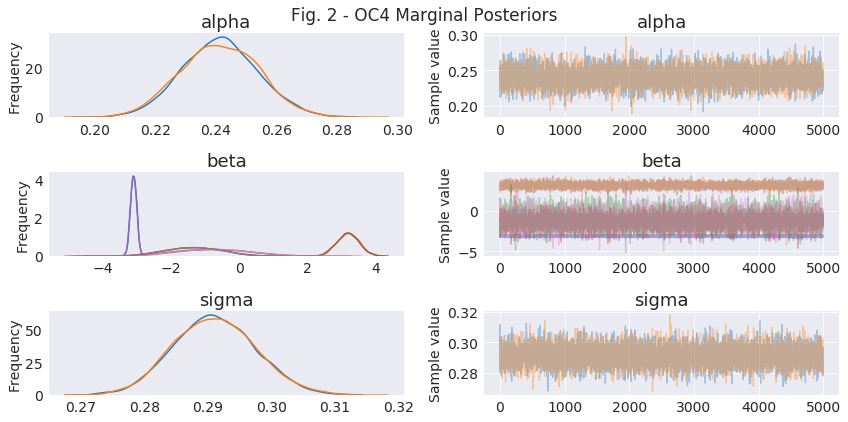

In [13]:
pm.traceplot(trace_oc4);
f= pl.gcf()
f.tight_layout()
f.suptitle('Fig. 2 - OC4 Marginal Posteriors');

The traces (right) have no apparent autocorrelation, a sign of good health with the sampler used here (Hamiltonian Monte Carlo). However, two of the $\beta$s seem conspicuously flat (left middle panel). Moreover, they straddle '$0$', which may indicate a problem. To try to tease out what might have gone wrong examining the marginal posteriors in more detail can help.

In [14]:
pm.summary(trace_oc4, alpha=0.08)

,mean,sd,mc_error,hpd_4,hpd_96,n_eff,Rhat
alpha,0.241241,0.012719,0.000171,0.219634,0.263820,5066.0,0.999916
beta__0,-3.107113,0.090762,0.001353,-3.261061,-2.949037,4311.0,1.000085
beta__1,3.179969,0.325871,0.005525,2.608276,3.730223,3751.0,1.000149
beta__2,-0.780740,1.061527,0.019800,-2.594780,1.054549,2798.0,1.000211
beta__3,-1.367985,0.836786,0.015062,-2.799372,0.091345,2941.0,1.000156
sigma,0.291094,0.006453,0.000080,0.279563,0.301963,6628.0,0.999905


The 'Rhat' column in the table above features entries close to $1$, another indication of good convergence. However, in the case of $\beta_2$ and $\beta_3$, the effective sample size (n_eff) is quite low relative to the 20000 total samples drawn for each; further clue to a potential problem. I'll plot the marginal posteriors again in more details; this time with '0' (green vertical) lines  drawn for reference.

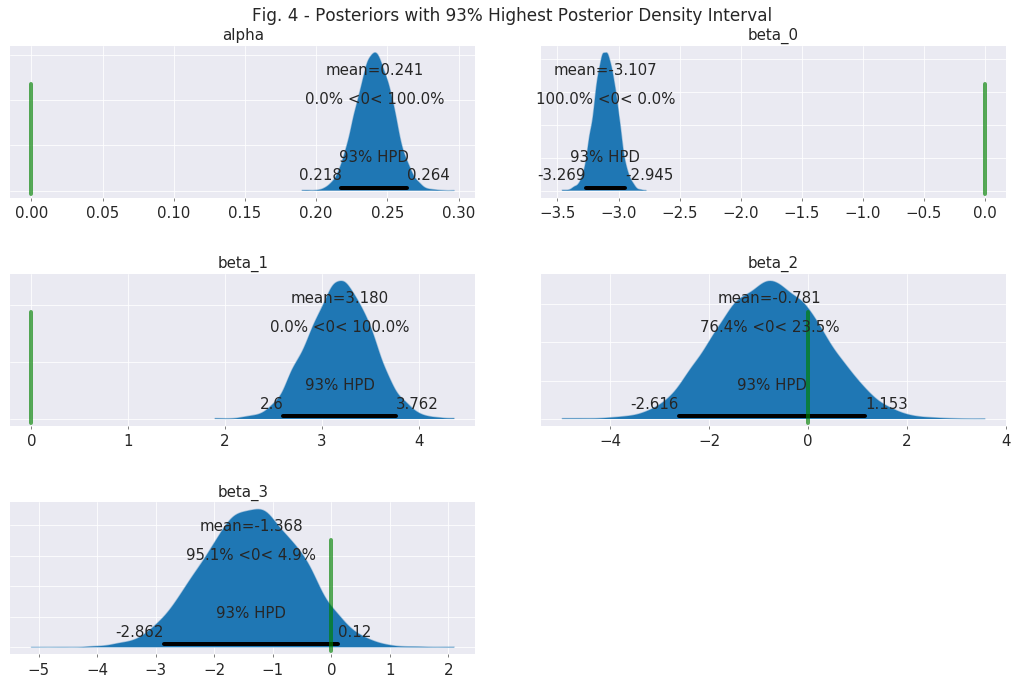

In [15]:
axs = pm.plot_posterior(trace_oc4, varnames=['alpha', 'beta'], ref_val=0, alpha_level=0.07,
                        kde_plot=True, shade=True, figsize=(15, 10));
f = pl.gcf()
f.suptitle('Fig. 4 - Posteriors with 93% Highest Posterior Density Interval');
f.tight_layout(pad=2.5)

The posteriors above feature a 93% **Highest Posterior Density Interval (HPDI)**. The  HPDI is the narrowest interval containing coefficient values with highest probability consistent with both data and, to varying degree, the prior. Note that I use 93% instead of a more common 95% interval as a reminder that there is nothing special about a 95% interval, related to the fetichization of the 0.05 p-value; a historical idiosyncrasy attributed [erroneously](http://www.radford.edu/~jaspelme/611/Spring-2007/Cowles-n-Davis_Am-Psyc_orignis-of-05-level.pdf) to R.A. Fisher.

Next is to examine pairwise relationships between marginal posteriors.

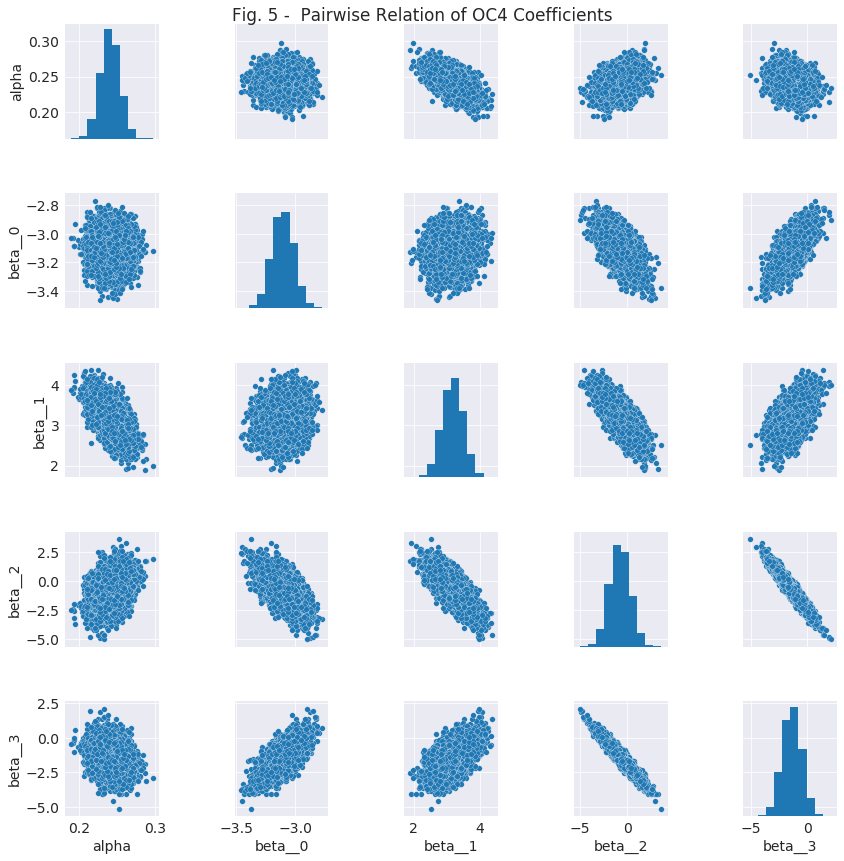

In [16]:
df_toc4 = pm.trace_to_dataframe(trace_oc4, varnames=['alpha', 'beta'])

sb.pairplot(data=df_toc4);
f = pl.gcf()
f.suptitle('Fig. 5 -  Pairwise Relation of OC4 Coefficients')
f.tight_layout(pad=2.5)

So $\beta_2$ and $\beta_3$ are highly correlated. This is a potential problem that reflects the inherent multicollinearity of high-order polynomial regressions. Multicollinearity refers to a strong correlation existing between two or more predictor variables used in a model, indicating that their information content is relatively similar. This can at best unnecessarily complicate the model, and on the nefarious end, can impede proper inference. The present model's predictors are made simply of different powers of the same variable. Another problem is that a model containing an unnecessarily lengthy set of predictors is prone to overfitting. Overfitting refers that although a model may perform well on training data, it does poorly when pit against out-of-sample (previously unseen) data. 

I'll use two different strategies, and therefore two variants of the regression model to attempt to tackle this potential problem. I will then compare all three models by evaluating their performance on out-of-sample data.
The first model will simply be a lesser, third, order polynomial regression. In the second model, I will keep the the polynomial's fourth power, but use weakly regularizing priors as a way to mitigate potential overfitting problems.

The third order polynomial looks like this:

$$ log_{10}\left(chlor\_a\right) = \alpha + \sum_{i=1}^{3}\beta_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

The code below describes the model and runs the inference

In [17]:
with pm.Model() as m_oc4_3:
    # flat priors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma_chl = pm.HalfNormal('sigma', sd=2)
    
    # likelihood:
    mu = alpha + beta[0] * mxBl2Gr + beta[1] * mxBl2Gr**2 + beta[2] * mxBl2Gr**3
    chlor_a_pred = pm.Normal('chlor_a_pred', mu=mu, sd=sigma_chl, observed=dfLogOC4.chlor_a)

In [18]:
with m_oc4_3:
    trace_oc4_3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:37<00:00, 158.33it/s]


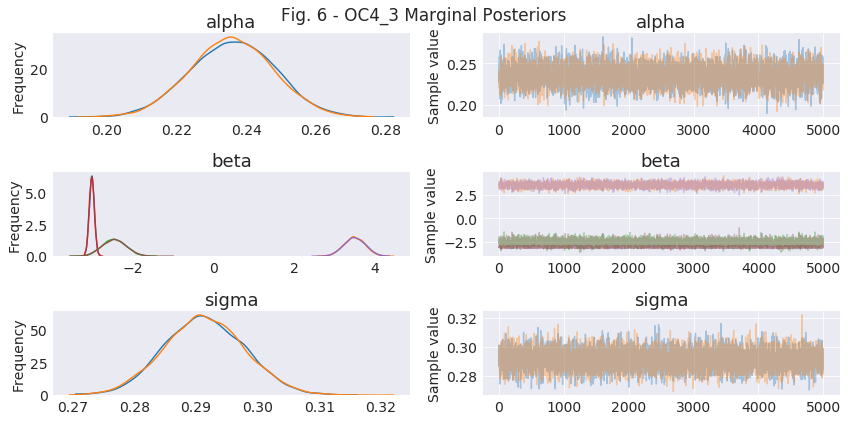

In [19]:
pm.traceplot(trace_oc4_3);
f= pl.gcf()
f.tight_layout()
f.suptitle('Fig. 6 - OC4_3 Marginal Posteriors');

In [20]:
pm.summary(trace_oc4_3,alpha=0.08)

,mean,sd,mc_error,hpd_4,hpd_96,n_eff,Rhat
alpha,0.235796,0.012120,0.000171,0.215220,0.257392,4775.0,1.000077
beta__0,-3.001490,0.062846,0.000768,-3.110242,-2.891986,5876.0,1.000213
beta__1,3.492644,0.261688,0.004363,3.030395,3.941186,3201.0,1.000023
beta__2,-2.450562,0.293800,0.004620,-2.959928,-1.950303,3631.0,0.999915
sigma,0.291331,0.006530,0.000072,0.280273,0.302945,6896.0,0.999901


Once again, the *Rhat* column suggests good convergence. Moreover, the highest posterior density columns (hpd) suggest no 0-straddling, which is encouraging. As for the previous model however, the problem of low n_eff is present; this time for $\beta_1$ and $\beta_2$. As before, examining pairwise relationships can be revealing:

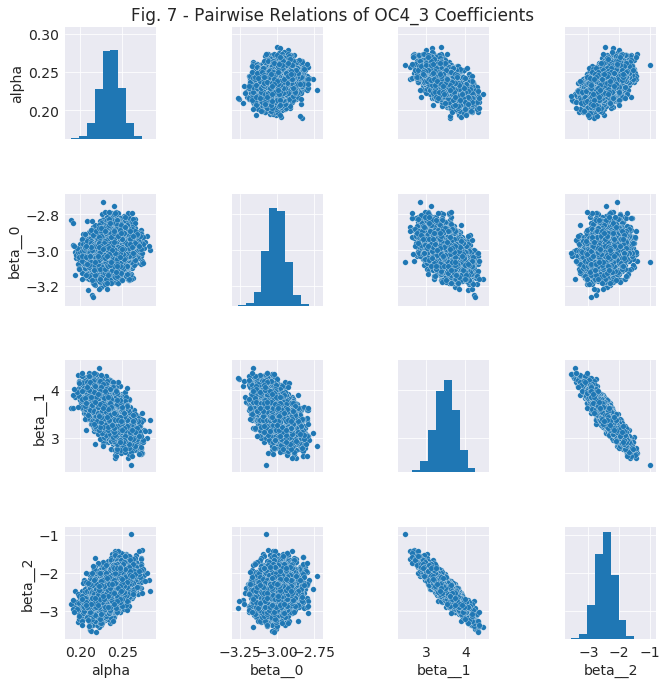

In [23]:
df_toc4_3 = pm.trace_to_dataframe(trace_oc4_3, varnames=['alpha', 'beta'])
sb.pairplot(df_toc4_3);
f = pl.gcf()
f.suptitle('Fig. 7 - Pairwise Relations of OC4_3 Coefficients');
f.tight_layout(pad=2.5)

And again, two of the slope coefficients $\beta_1$ and $\beta_2$ track each other, seemingly adding  little information. At this point, this mirrors the concern raised earlier and suggests a problem with the model structure itself. A potential improvement in this instance is that, as seen below, none of the posterior marginals overlaps the '$0$' line. However one should keep in mind that $\beta_2$'s HPDI is still quite wide, reflecting the uncertainty of its inference.

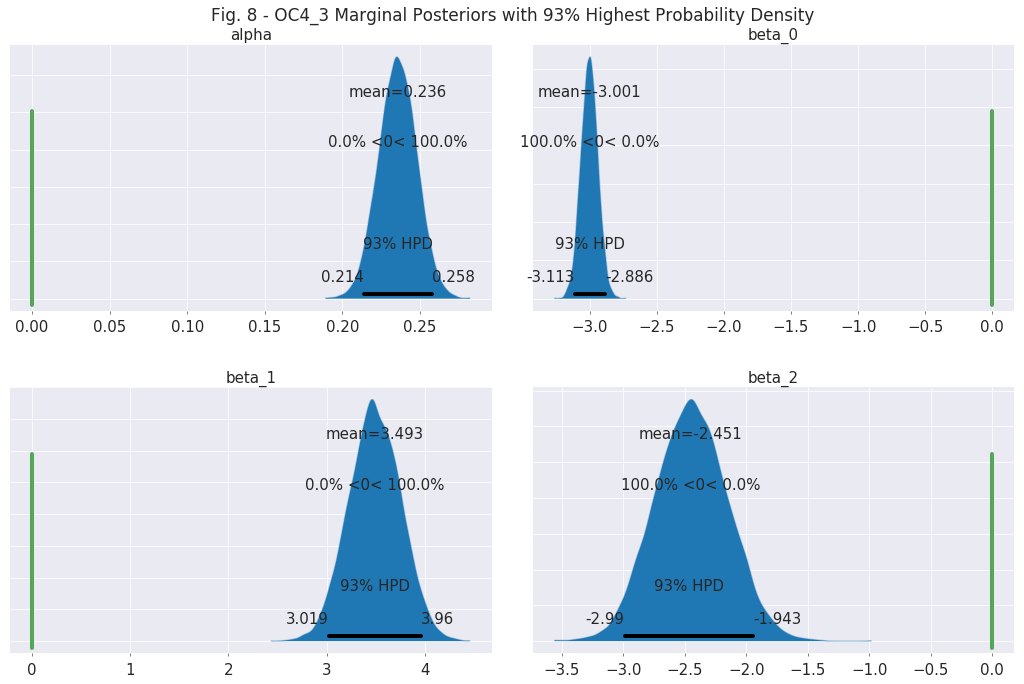

In [24]:
axs = pm.plot_posterior(trace_oc4_3, varnames=['alpha', 'beta'],
                        ref_val=0, alpha_level=0.07, kde_plot=True, shade=True, figsize=(15, 10));
f = pl.gcf()
f.suptitle('Fig. 8 - OC4_3 Marginal Posteriors with 93% Highest Probability Density')
f.tight_layout(pad=2.5)

Finally, as a way to guard against overfitting, we'll use weakly regularizing priors. I do this by simply changing the standar deviation of the gaussian priors from 10 to 1. The code below describes this variant's implementation, which I will label m_oc4_r:

In [25]:
with pm.Model() as m_oc4_r:
    # weakly regularizing priors:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1, shape=4)
    sigma_chl = pm.HalfNormal('sigma', sd=2)
    
    # likelihood:
    mu = alpha + beta[0] * mxBl2Gr + beta[1] * mxBl2Gr**2 + beta[2] * mxBl2Gr**3 + beta[3] * mxBl2Gr**4
    chlor_a_pred = pm.Normal('chlor_a_pred', mu=mu, sd=sigma_chl, observed=dfLogOC4.chlor_a)
    trace_oc4_r = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [01:32<00:00, 64.89it/s]


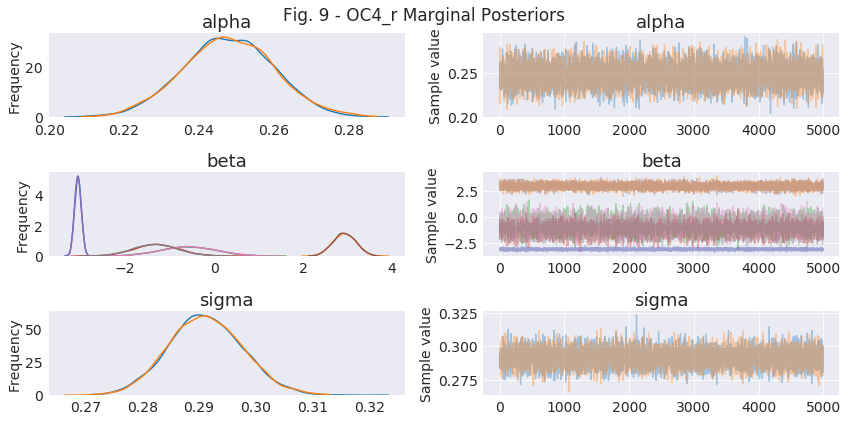

In [26]:
pm.traceplot(trace_oc4_r);
f = pl.gcf()
f.tight_layout()
f.suptitle('Fig. 9 - OC4_r Marginal Posteriors');

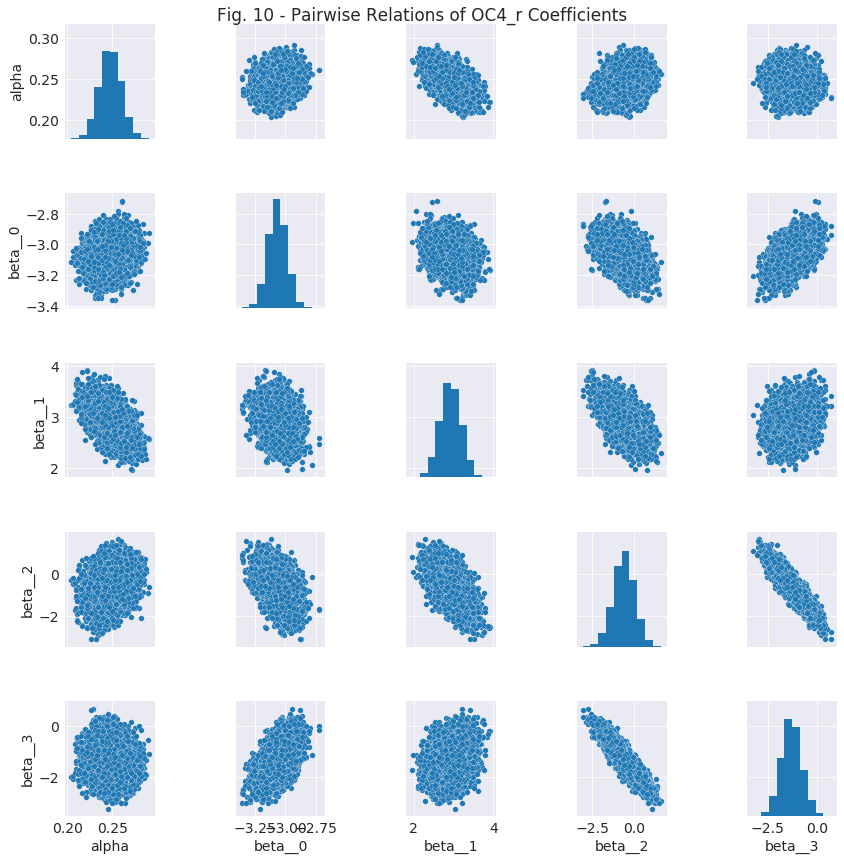

In [29]:
df_toc4_r = pm.trace_to_dataframe(trace_oc4_r, varnames=['alpha', 'beta'])
sb.pairplot(df_toc4_r);
f = pl.gcf()
f.suptitle('Fig. 10 - Pairwise Relations of OC4_r Coefficients');
f.tight_layout(pad=2.5)

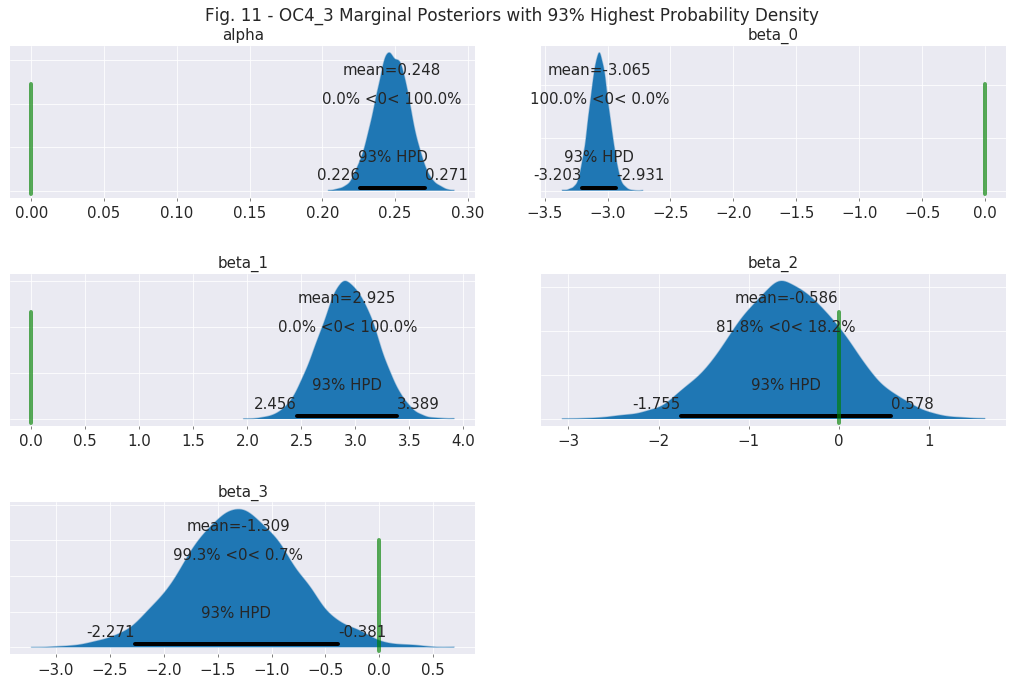

In [30]:
axs = pm.plot_posterior(trace_oc4_r, varnames=['alpha', 'beta'],
                        ref_val=0, alpha_level=0.07, kde_plot=True, shade=True, figsize=(15, 10));
f = pl.gcf()
f.suptitle('Fig. 11 - OC4_3 Marginal Posteriors with 93% Highest Probability Density')
f.tight_layout(pad=2.5)

The regularized model already features tighter HPDIs, and the $\beta_3$ coefficient is already no longer straddling the 0 line.
Next is to compare models and assess uncertainties.

### Model Posteriors and Uncertainty

Steps:
* create a mock max(blue)/green dataset, $input_{grid}$ in the code below, ranging a little outside of the observed data, on either side
* compute posterior (deterministic) chlor_a distribution at each $input_{grid}[i]$
* get credibility interval around mean chlor_a along $input_{grid}$ 

First to create *the mock dataset*:

In [31]:
input_grid = np.linspace(-0.45, 1.3, 100).reshape(-1, 1)

Now to compute modeled chlor_a distribution at each $x_i$. I first write a function to avoid duplicating code.

In [32]:
def get_modeled_y(trace, grid):
    """this computes posterior predictive on arbitrary input"""
    mu_y = np.zeros((len(grid), len(trace) * trace.nchains))
    for i, point_i in enumerate(grid):
        mu_y[i] = trace['alpha'] # add intercept
        for j in range(trace['beta'].shape[1]):
            point_i_ = point_i **(j+1)
            mu_y[i] += point_i_ * trace['beta'][:, j]
    return mu_y

Get modeled data distributions...

In [33]:
mu_oc4 = get_modeled_y(trace_oc4, input_grid)
mu_oc4_3 = get_modeled_y(trace_oc4_3, input_grid)
mu_oc4_r = get_modeled_y(trace_oc4_r, input_grid)

Compute model stats...

In [34]:
# compute model stats
def get_model_stats(mu_y):
    mu_y_med = np.median(mu_y, axis=1)
    mu_y_hpd = pm.hpd(mu_y.T) # 95% credible intervals
    return mu_y_med, mu_y_hpd

mu_oc4_med, mu_oc4_hpd = get_model_stats(mu_oc4)
mu_oc4_3_med, mu_oc4_3_hpd = get_model_stats(mu_oc4_3)
mu_oc4_r_med, mu_oc4_r_hpd = get_model_stats(mu_oc4_r)

Plot results:

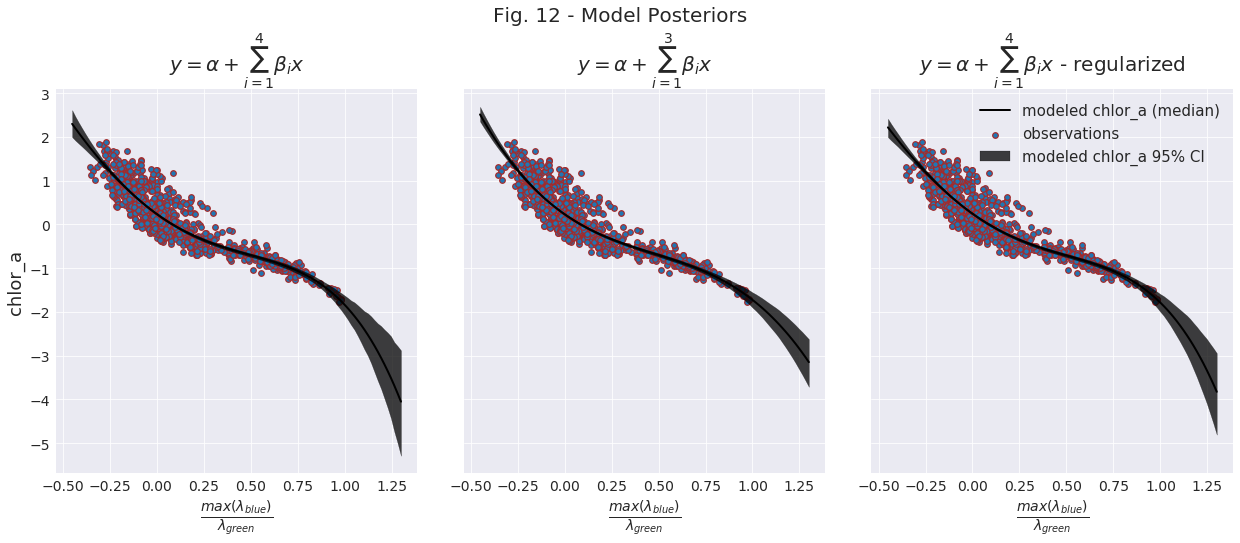

In [39]:
f, axs = pl.subplots(ncols=3, figsize=(18, 8), sharey=True)
f.suptitle('Fig. 12 - Model Posteriors', fontsize=20)
# -- oc4
axs[0].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2)
axs[0].plot(input_grid, mu_oc4_med, color='k', lw=2)
axs[0].set_ylabel('chlor_a', fontsize=18)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$',
                  fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$',
                 fontsize=20, y=1.03 )
axs[0].fill_between(input_grid.ravel(), mu_oc4_hpd[:, 0],
                    mu_oc4_hpd[:, 1],
                    color='k', alpha=0.75)
# -- oc4_3
axs[1].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown',
               linewidth=1.2, label='observations')
axs[1].plot(input_grid, mu_oc4_3_med, color='k', lw=2,
            label='modeled chlor_a (median)')
axs[1].fill_between(input_grid.ravel(), mu_oc4_3_hpd[:, 0], mu_oc4_3_hpd[:, 1], color='k',
                    alpha=0.75, label='modeled chlor_a 95% CI')
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
# -- oc4_r
axs[2].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown',
               linewidth=1.2, label='observations')
axs[2].plot(input_grid, mu_oc4_r_med, color='k', lw=2,
            label='modeled chlor_a (median)')
axs[2].fill_between(input_grid.ravel(), mu_oc4_r_hpd[:, 0], mu_oc4_r_hpd[:, 1], color='k',
                    alpha=0.75, label='modeled chlor_a 95% CI')
axs[2].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[2].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$ - regularized' ,
                 fontsize=20, y=1.03 )
axs[2].legend(fontsize=15);
f.tight_layout(pad=2.5)

Outside of the range where training data is available, the credibility intervals widen rapidly, though to varying degrees. The fourth order regression features the widest intervals, while the third order regression the narrowest. The regularized fourth order regression sits between the two others in that respect. 

On the other hand, the 95% credibility intervals around mean predicted chlorophyll are quite tight for all three models, within the range where the training data is available. How then to explain the spread in the data?
This happens because there is not much ambiguity around the *modeled* (expected) chlor_a at a given input value; the modeled chlor_a is deterministic, rather than probabilistic.  
The key to exploring chlorophyll as a probabilistic construct conditioned on input $\frac{max(\lambda_{blue})} {\lambda_{green}}$
is the **<u>posterior predictive</u>**.


### Future Data Simulation and the Posterior Predictive
* Bayesian models are generative.
* This means that they enable simulation of future data $\rightarrow$ <u>posterior predictives</u>
* Posterior predictives: distribution of unobserved events ($chlor\_a_{new}$) conditioned on previous observations, after the $\alpha$ and $\beta$s have been marginalized over all possible values:
$$ p(chlor\_a_{new}\mid chlor\_a_{observed}) = \int\int p(chlor\_a_{new}\mid \alpha,\beta)\ p(\alpha,\beta \mid chlor\_a_{observed})\ d\alpha\ d\beta$$
* This enables model cross-validation in the absence of out-of-sample data.

The library I use, PyMC3, makes it easy to sample from the posterior predictives. Below I do that for both models

In [40]:
ppc_oc4 = pm.sample_ppc(trace_oc4, 1000, m_oc4, )['chlor_a_pred'] # posterior predictive for m_oc4
ppc_oc4_3 = pm.sample_ppc(trace_oc4_3, 1000, m_oc4_3)['chlor_a_pred'] # posterior predictive for m_oc4_3
ppc_oc4_r = pm.sample_ppc(trace_oc4_r, 1000, m_oc4_r, )['chlor_a_pred'] # posterior predictive for m_oc4_r
hpd_95_ppc_oc4 = pm.hpd(ppc_oc4) # 95% credibility interval for ppc_oc4
hpd_95_ppc_oc4_3 = pm.hpd(ppc_oc4_3) # 95% credibility interval for ppc_oc4_3
hpd_95_ppc_oc4_r = pm.hpd(ppc_oc4_r) # 95% credibility interval for ppc_oc4_r
med_ppc_oc4 = np.median(ppc_oc4, axis=0)
med_ppc_oc4_3 = np.median(ppc_oc4_3, axis=0)
med_ppc_oc4_r = np.median(ppc_oc4_r, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]


Next is to plot the posterior predictives along with the trainig dataset, for both models. Because these represent distributions of as yet unobserved data, the resulting intervals are quite a bit larger. They also represent an estimate of where there is a, in this case, 95% chance that a future data point will be observed.

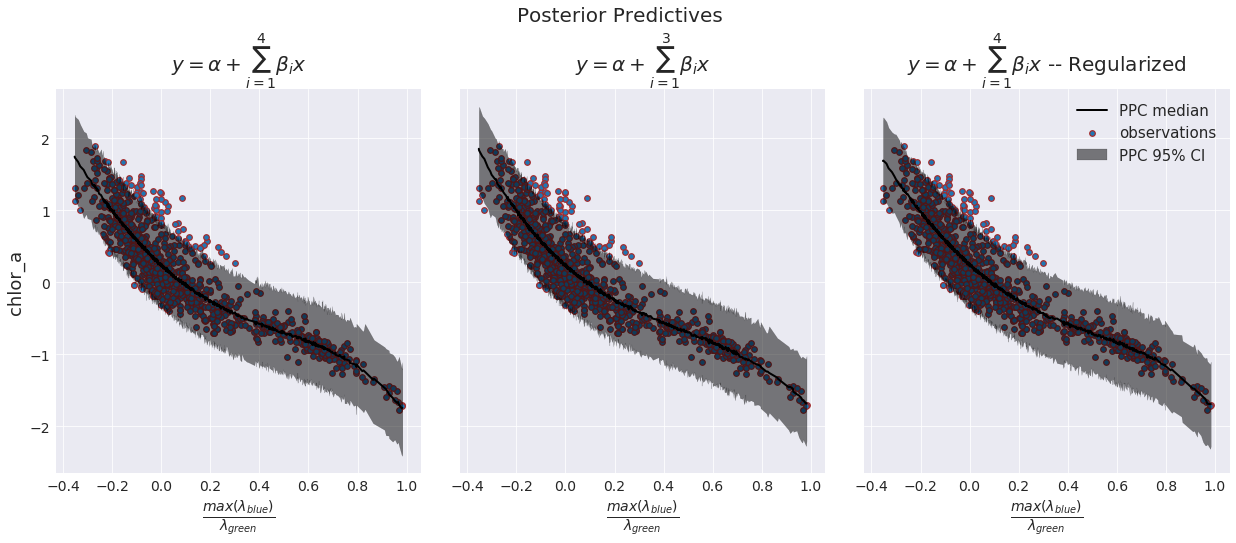

In [43]:
f, axs = pl.subplots(ncols=3, figsize=(18, 8), sharey=True)
f.suptitle('Posterior Predictives', fontsize=20)
ix=np.argsort(dfLogOC4.mxBl2Gr)
# -- oc4
axs[0].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, edgecolor='brown', linewidth=1.2)
axs[0].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4[ix], color='k', lw=2)
axs[0].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0],
                    hpd_95_ppc_oc4[ix, 1], alpha=0.5, color='k')
axs[0].set_ylabel('chlor_a', fontsize=18)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$', fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$', fontsize=20, y=1.03 )
# -- oc4_3
axs[1].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, label='observations', edgecolor='brown', linewidth=1.2)
axs[1].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_3[ix], color='k', label='PPC median', lw=2)
axs[1].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4_3[ix,0],
                    hpd_95_ppc_oc4_3[ix, 1], alpha=0.5, color='k', label='PPC 95% CI')
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
# -- oc4_r
axs[2].scatter(dfLogOC4.mxBl2Gr, dfLogOC4.chlor_a, label='observations', edgecolor='brown', linewidth=1.2)
axs[2].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_r[ix], color='k', label='PPC median', lw=2)
axs[2].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4_r[ix,0],
                    hpd_95_ppc_oc4_r[ix, 1], alpha=0.5, color='k', label='PPC 95% CI')
axs[2].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[2].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$ -- Regularized', fontsize=20, y=1.03)
axs[2].legend(fontsize=15);
f.tight_layout(pad=2.5)

All three models show relative consensus on the expectation of new data. Note however that this expectation is strictly within the bounds of available training data. This is fine if one does not expect new data to stray outside of this range, but can yield unexpected results otherwise, as hinted to by the previous plot featuring a grid of mock input data. This is not a long term problem, since when new data becomes available, the inference can be augmented by including those and using the current posterior as a prior for the new inference.

### Information Theoretic Assessment of Future Performance

One popular way of comparing models is the Widely Available Information Criterion. The name is indicative of Watanabe's humor, since as the inventor of the metric, he could have gone with the more flattering and perhaps more informative Watanabe Akaike Information Criterion label. The fact remains that this is a very versatile construct; bayesian in nature by its virtue of using the full posterior distribution, in addition to penalizing model complexity much like its frequentist cousin, the AIC.

WAIC is based on a clever trick of pairwise subtracting Kullback-Leibler divergences, each of which specifies the divergence  between the model posterior and the never observed *true posterior*. The distribution of the true posterior drops out, leaving just pairwise deviances between the models themselves. 

In practice, WAIC is made of two parts; a pointwise computation of the likelihood of the N data points of the training dataset conditioned on the posterior ($lppd$ for *log pointwise predictive density*), and the effective number of parameters ($p_{waic}$), reminiscent of the better known AIC. $p_{waic}$ is computed by summing the variances of the log likelihood of each observation. In summary:

$$ WAIC = -2( lppd - p_{waic})$$
with,
$$lppd = \sum_{i=1}^N log(y_i \mid \theta_{post})$$
where $\theta_{post}$ is the posterior distribution of model coefficients (unobserved variables $\alpha$ and $\beta$s in the present case), and, 
$$p_{waic} = \sum_{i=1}^N V(y_i)$$
where $V(y_i)$ is the variance of observation $i$.
 

Below, I create a dataframe based on WAIC, designed to help the practitioner make some decisions on how best to use the models. Models are sorted by decreasing performance (increasing WAIC).

For illustrative purposes I first build a WAIC table with the first two unregularized models. Later I repeat this step with all three models. The reason for doing so will become readily apparent.

In [44]:
models = [m_oc4, m_oc4_3]
traces = [trace_oc4, trace_oc4_3]
mdl_names = ['m_oc4', 'm_oc4_3']
df_comp = pm.compare(traces=traces, models=models)
df_comp.index = [mdl_names[i] for i in df_comp.index]
df_comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
m_oc4,379.59,5.56,0,0.62,56.42,0,0
m_oc4_3,380.22,4.65,0.63,0.38,56.59,3.14,0


** How to read this table**: 
* each row corresponds to a model, listed by decreasing order of performance (decreasing WAIC).
* WAIC: predicted out-of-sample deviance; the lower the better;
* pWAIC: corresponds to the effective number of "parameters"; i.e. model flexibility. The greater the number the more flexible the model is, but the more it tends to overfit;
* dWAIC: difference between current model WAIC and best (top row) model WAIC;
* weight: Akaike weight, estimate of probability of model performance on new data conditioned on models considered;
* SE: standard error of WAIC as an estimate; i.e. measure of its uncertainty;
* dSE standard error of dWAIC;
* warning: a value of 1 invites caution. When this occurs multiple approaches should be used for model comparison. This includes directly comparing models using the Leave-One-Out (LOO) cross-valiadation technique, or indirectly through the use of PPCs and out-of-sample testing;

Overall, the $4^{th}$ degree polynomial is expected to do marginally better. However the WAICs are quite close and the associated 'weight' of the top model is far from *$1$*. This suggests that better performance can be expected from combining both models. Model combination is done using the weights; *cf.* table above. These weights, often referred to as *Akaike weights* constitute a probabilistic assessment of model performance on future data. Weights and corresponding models are combined by ensemble averaging, where each weight informs the influence of the corresponding model. Put simply, an ensemble average can be build by weighing the traces of both models with their corresponding Akaike weights. The resulting prediction has a greater probability of accuracy.

Let's see how the regularized model fare in comparison:

In [57]:
models = [m_oc4, m_oc4_3, m_oc4_r]
traces = [trace_oc4, trace_oc4_3, trace_oc4_r]
mdl_names = ['m_oc4', 'm_oc4_3', 'm_oc4_r']
df_comp = pm.compare(traces=traces, models=models)
df_comp.index = [mdl_names[i] for i in df_comp.index]
df_comp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
m_oc4_r,379.01,4.71,0,0.58,55.8,0,0
m_oc4,379.59,5.56,0.58,0,56.42,2.3,0
m_oc4_3,380.22,4.65,1.21,0.42,56.59,4.68,0


Here the regularized prior has scored better than the other two. And even though the  unregularized fourth order model, m_oc4, has a lower (better) WAIC score than that of the unregularized third order m_oc4_3, the latter has a smaller number of effective parameters (pWAIC). This difference is deemed sufficient to yield a greater probability of better performance on unseen data because of a lesser chance of overfitting. 

### Out-of-sample testing

Nothing really beats out-of-sample testing with real unseen data.
First I'm going to load out-of-sample data spanning the years 2008-2010, i.e. outside the data used to fit the model with the latest record dating back to 2007:

In [45]:
dfNomadV2.datetime.dt.year.max()

2007

Now to load and shape the test set obtained from [SeaBASS](https://seabass.gsfc.nasa.gov/).

In [46]:
df_test_raw = pd.read_pickle('./pickleJar/SwfTestCl.pkl')
df_test_raw.head(2).T

,0,1
id,280136,279946
latitude,29.0527,23.0139
longitude,-87.3232,59.9755
date_time,2010-05-13 21:02:00,2010-03-10 11:37:00
cruise,2010_05_wbii,abudhabi-masqat
seawifs_filename,S2010133195617.L2_MLAC.R0000020308_2010_05_wbi...,S2010069095904.L2_GAC.R0000020316_abudhabi-mas...
seawifs_es_error,0,0
seawifs_pixel_total,25,25
seawifs_tdiff,-2866,-5159
seawifs_solz,35.43,40.02


In the next few code cells, I'll create the test set.

In [47]:
# convert date_time entries to python datetime objects for easy manipulation.
df_test_raw['date_time'] = pd.to_datetime(df_test_raw.date_time)

In [48]:
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 116
Data columns (total 21 columns):
id                     97 non-null int64
latitude               97 non-null float64
longitude              97 non-null float64
date_time              97 non-null datetime64[ns]
cruise                 97 non-null object
seawifs_filename       97 non-null object
seawifs_es_error       97 non-null float64
seawifs_pixel_total    97 non-null int64
seawifs_tdiff          97 non-null int64
seawifs_solz           97 non-null float64
seawifs_senz           97 non-null float64
seawifs_cv             97 non-null float64
seawifs_windspeed      97 non-null float64
seawifs_chlor_a        97 non-null float64
insitu_chlor_a         97 non-null float64
seawifs_rrs412         97 non-null float64
seawifs_rrs443         97 non-null float64
seawifs_rrs490         97 non-null float64
seawifs_rrs510         97 non-null float64
seawifs_rrs555         97 non-null float64
seawifs_rrs670         97 non-null fl

In [49]:
# check the data is indeed out-of-sample:
bound_years = df_test_raw.date_time.dt.year.min(), df_test_raw.date_time.dt.year.max()
print(f'test dataset bounding years: {bound_years[0]} - {bound_years[1]}')

test dataset bounding years: 2008 - 2010


In [50]:
# Create test data set in the image of the training data set:
df_test = df_test_raw.filter(regex='rrs')
df_test.insert(df_test.shape[1], 'swf_chlor_a', df_test_raw.seawifs_chlor_a)
df_test.insert(df_test.shape[1], 'is_chlor_a', df_test_raw.insitu_chlor_a)

# shorten rrs column_names
ren_cols = df_test.filter(regex='rrs').columns.tolist()
df_test = df_test.rename(columns={col: col.split('_')[1] for col in ren_cols})

df_test.insert(0, 'id', df_test_raw.id)
df_test.insert(df_test.shape[1]-2, 'maxBlue', df_test[['rrs443','rrs490','rrs510']].max(axis=1))
df_test.insert(df_test.shape[1]-2, 'mxBl2Gr', df_test.maxBlue / df_test.rrs555)
df_test.head()

,id,rrs412,rrs443,rrs490,rrs510,rrs555,rrs670,maxBlue,mxBl2Gr,swf_chlor_a,is_chlor_a
0,280136,0.004372,0.004484,0.003964,0.002830,0.001421,-0.000017,0.004484,3.155524,0.199851,0.17375
1,279946,-0.001591,0.000155,0.001437,0.001844,0.001949,0.000624,0.001844,0.946126,2.625748,1.34200
2,279960,0.004927,0.005084,0.004807,0.003134,0.001602,0.000155,0.005084,3.173533,0.209590,0.11800
3,293134,0.002161,0.001858,0.002458,0.002803,0.004000,0.000722,0.002803,0.700750,7.501433,1.20107
4,279633,-0.000083,0.001636,0.003643,0.004140,0.004578,0.000722,0.004140,0.904325,2.766071,1.74300


In [51]:
dfLogOC4_test = pd.concat((df_test[['id']], np.log(df_test[['mxBl2Gr', 'swf_chlor_a', 'is_chlor_a']])), axis=1)

I am only going to retain in situ chlorophyll data, since the swf_chlor_a is reflects the operational chlorophyll algorit

Now that I have a test set, I will quickly examine it to make sure all seems fine.

In [52]:
dfLogOC4_test.head()

,id,mxBl2Gr,swf_chlor_a,is_chlor_a
0,280136,1.149155,-1.610183,-1.750138
1,279946,-0.055379,0.965366,0.294161
2,279960,1.154846,-1.562602,-2.137071
3,293134,-0.355604,2.015094,0.183213
4,279633,-0.100566,1.017428,0.555608


In [53]:
dfLogOC4_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 116
Data columns (total 4 columns):
id             97 non-null int64
mxBl2Gr        97 non-null float64
swf_chlor_a    97 non-null float64
is_chlor_a     97 non-null float64
dtypes: float64(3), int64(1)
memory usage: 3.8 KB


Next is to create modeled chlorophyll from the test set and plot along side the inference results from earlier:

In [54]:
mod_chl_test_oc4 = get_modeled_y(trace_oc4, dfLogOC4_test.mxBl2Gr.values)
mod_chl_test_oc4_3 = get_modeled_y(trace_oc4_3, dfLogOC4_test.mxBl2Gr.values)
mod_chl_test_oc4_r = get_modeled_y(trace_oc4_r, dfLogOC4_test.mxBl2Gr.values)

In [58]:
# get modeled chl stats for test data:
chl_test_oc4_med, chl_test_oc4_hpd = get_model_stats(mod_chl_test_oc4)
chl_test_oc4_3_med, chl_test_oc4_3_hpd = get_model_stats(mod_chl_test_oc4_3)
chl_test_oc4_r_med, chl_test_oc4_r_hpd = get_model_stats(mod_chl_test_oc4_r)

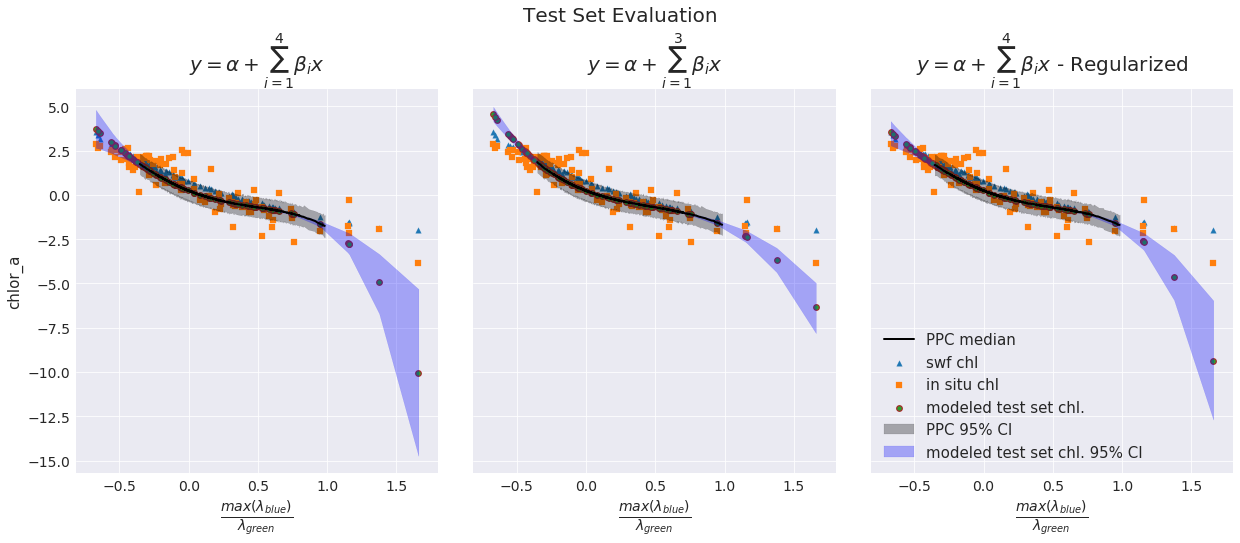

In [66]:
f, axs = pl.subplots(ncols=3, figsize=(18, 8), sharey=True)
f.suptitle('Test Set Evaluation', fontsize=20)
ix=np.argsort(dfLogOC4.mxBl2Gr)
ix_test = np.argsort(dfLogOC4_test.mxBl2Gr)
# -- oc4
axs[0].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.swf_chlor_a, marker='^')
axs[0].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.is_chlor_a, marker='s')
axs[0].scatter(dfLogOC4_test.mxBl2Gr, chl_test_oc4_med, edgecolor='brown', linewidth=1.2)
axs[0].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4[ix], color='k', lw=2)
axs[0].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4[ix,0],
                    hpd_95_ppc_oc4[ix, 1], alpha=0.3, color='k')
axs[0].fill_between(dfLogOC4_test.mxBl2Gr.values[ix_test], chl_test_oc4_hpd[ix_test, 0],
                   chl_test_oc4_hpd[ix_test, 1], alpha=0.3, color='b')
axs[0].set_ylabel('chlor_a', fontsize=15)
axs[0].set_xlabel(r'$\frac{ max( \lambda_{blue} ) }{\lambda_{green}}$', fontsize=20)
axs[0].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$', fontsize=20, y=1.03 )
# -- oc4_3
axs[1].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.swf_chlor_a, marker='^', label='swf chl')
axs[1].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.is_chlor_a, marker='s', label='in situ chl')
axs[1].scatter(dfLogOC4_test.mxBl2Gr, chl_test_oc4_3_med, edgecolor='brown', linewidth=1.2,
               label='modeled test set chl.')
axs[1].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_3[ix], color='k', label='PPC median', lw=2)
axs[1].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4_3[ix,0],
                    hpd_95_ppc_oc4_3[ix, 1], alpha=0.3, color='k',
                   label='PPC 95% CI')
axs[1].fill_between(dfLogOC4_test.mxBl2Gr.values[ix_test], chl_test_oc4_3_hpd[ix_test, 0],
                   chl_test_oc4_3_hpd[ix_test, 1], alpha=0.3, color='b')
axs[1].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[1].set_title(r'$y = \alpha + \sum_{i=1}^3\beta_ix$', fontsize=20, y=1.03)
# -- oc4_r
axs[2].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.swf_chlor_a, marker='^', label='swf chl')
axs[2].scatter(dfLogOC4_test.mxBl2Gr, dfLogOC4_test.is_chlor_a, marker='s', label='in situ chl')
axs[2].scatter(dfLogOC4_test.mxBl2Gr, chl_test_oc4_r_med, edgecolor='brown', linewidth=1.2,
               label='modeled test set chl.')
axs[2].plot(dfLogOC4.mxBl2Gr.values[ix], med_ppc_oc4_r[ix], color='k', label='PPC median', lw=2)
axs[2].fill_between(dfLogOC4.mxBl2Gr.values[ix], hpd_95_ppc_oc4_r[ix,0],
                    hpd_95_ppc_oc4_r[ix, 1], alpha=0.3, color='k',
                   label='PPC 95% CI')
axs[2].fill_between(dfLogOC4_test.mxBl2Gr.values[ix_test], chl_test_oc4_r_hpd[ix_test, 0],
                   chl_test_oc4_r_hpd[ix_test, 1], alpha=0.3, color='b', label='modeled test set chl. 95% CI')
axs[2].set_xlabel(r'$\frac{max(\lambda_{blue})} {\lambda_{green}}$', fontsize=20)
axs[2].set_title(r'$y = \alpha + \sum_{i=1}^4\beta_ix$ - Regularized', fontsize=20, y=1.03)
axs[2].legend(fontsize=15);
f.tight_layout(pad=2.5)

A number of observations can be made from the plot above:
* Satellite data is displayed for reference.
* Quite a bit of the data is outside the range of the training data set. This becomes a problem for out of range prediction of unseen data. That said, when such data becomes available, it, and its inherent noise can be integrated into an updated inference, which can then be expected to perform better on the next batch of unseen data.
* The test data appears noisier than the training data. This is confirmed by the number of data points outside  the 95% PPC CI (i.e. the interval in which new data is expected to occur). 
    * It highlights the importance of statistical difference between training and testing data. The training data's statistical characteristics must reflect the nature of the data that the model will be encountering operationally. Thus selecting well behaved data for training and model development purposes can undermine prediction of unseen data.
    * Noise in the data does not necessarily constitute a problem. The probabilistic modeling framework used here can address this if error estimation of the data is available. The data, both predictor and predicted variables, can be explicitly modeled as samples drawn from a larger population distribution, potentially yielding better predictions, and more importantly better estimates of uncertainty around the predictions. In other words, and counterintuitively, if possible, modeling the data is better than using it straight out of the box, provided its statistics are well understood.
* the 4th order polynomial, deals better with high-chlorophyll samples and does a better job of predicting uncertainty in that range as shown by the 95% CI of the modeled test chlorophyll.
* the 3rd order polynomial handles the chlorophyll values better, but does a slightly worse job of predicting the uncertainty. This difference in "opinion" between the two models justify using them in combination.
* for the purpose of combining models, the WAIC weights estimated above provide a principled way of combining models by ensemble averaging. More often than not, this is the recommended procedure. I will demonstrate this in subsequent posts after I've developed a few more models. To that effect, I serialize models, traces and datasets so that these remain available, without using too much disk space. Doing so means that the models can be reused in production, for comparison with other models developed by myself or others, and for easy sharing and reproducibility.

In [289]:
with open('./pickleJar/models.pkl', 'wb') as fmod:
    mod_dict = dict(models=dict(oc4=m_oc4,oc4_3=m_oc4_3),
                     traces=dict(oc4=trace_oc4, oc4_3=trace_oc4_3)
                    )
    pickle.dump(mod_dict, fmod)
with open('./pickleJar/datasets.pkl', 'wb') as fdat:
    dataset_dict = dict(swf=dict(train=dfLogOC4, test=dfLogOC4_test))
    pickle.dump(dataset_dict, fdat)

Steps forward:

    1 - ensemble averaging, particularly after experimenting with a few more models. A WAIC analysis can then yield Akaike weights that can be used to weight each model's contribution.
    2 - there are some possible clustering information available in the original NOMAD data set. The conventional approach, also used here, of pooling all available data to obtain a single set of regression coefficients can result in significant information loss. The next post will detail development of bayesian generalized linear models that makes use of such grouping information.
    3 - the data set used for training is inadequate, a discussion of how to incorporate more data is required; particularly because bayesian modeling can offer mitigating mechanisms for subpar data that may nevertheless contain usable information. The NOMAD dataset, for instance, is quite good for model development, but the final fit for an operational version of the model should come from matchup data that is statistically well characterized, e.g. with accompanying standard error around the measurements.
    4 - high-order polynomial regression is generally a bad idea, as the inherent multicollinearity can hinder the inference. Moreover, a high-order polynomial regression means coefficients are difficult if not impossible to interpret. Model development by "first principles" should avoid these altogether. This is particularly true when incrementally adding other potential predictors, e.g. temperature, either by linear combination or by formulation of interactions among predictors, for the purpose of building a more discerning model. The process of incrementally building alternative models will be the subject of a subsequent post.